In [1]:
import numpy as np
from scipy import ndimage
from PIL import Image, ImageOps
import cv2
import os
import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt 
import tensorflow
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, \
     Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
from tensorflow.keras import optimizers
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix
import itertools

Spliting the dataset into training and testing

In [2]:
input_dir = './Ekush_Cleaned'
output_dir = './Ekush_Cleaned_Output'
splitfolders.ratio(input_dir, output_dir, seed=1337, ratio=(0.8, 0.2))

In [3]:
# Change root_dir as you need
root_dir = './Ekush_Cleaned_Output'

for root, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(root, filename)

        # Load the image
        img = cv2.imread(file_path)
        
        # Changing the image color space from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Invert the image
        img = cv2.bitwise_not(img)

        # Resize the image
        img = cv2.resize(img, (32, 32))

        # Save the image
        cv2.imwrite(file_path, img)


In [4]:
img = cv2.imread(
    '/home/nsssayom/Desktop/compound-bangla-char/Ekush_Cleaned_Output/train/60/0_B.BARI_10_1_365.jpg')
print (img.shape)

(32, 32, 3)


In [5]:
train_data_dir = './Ekush_Cleaned_Output/train'
validation_data_dir = './Ekush_Cleaned_Output/val'

In [6]:
img_width, img_height, c = 32, 32, 3
batch_size=64

In [7]:
datagen = ImageDataGenerator(rescale=1. / 255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= True,
        class_mode = 'categorical')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= False,
        class_mode = 'categorical')

Found 50476 images belonging to 50 classes.
Found 12639 images belonging to 50 classes.


In [8]:
IMG_SHAPE = 32, 32, 3
classes=50

In [9]:
nb_epoch = 30
nb_train_samples = 50476
nb_validation_samples = 12639


In [10]:
def bn_rl_conv(x, filters, kernel_size):
    # x = BatchNormalization()(x)
    x = ELU()(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x =  tensorflow.keras.layers.Dropout(0.1)(x)
    
    return x

In [11]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_rl_conv(tensor, filters=4*k, kernel_size=1)
        x = bn_rl_conv(x, filters=k, kernel_size=3)
        # x =  tensorflow.keras.layers.Dropout(0.1)(x)
        tensor = Concatenate()([tensor, x])
    return tensor

In [12]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_rl_conv(x, filters=f, kernel_size=1)
    # x =  tensorflow.keras.layers.Dropout(0.1)(x)
    # x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

In [13]:
IMG_SHAPE = 32, 32, 3
k = 10
theta = 0.5
repetitions = 10, 10, 12


input = Input(IMG_SHAPE)

In [14]:
x = Conv2D(2*k, 7, strides=2, padding='same')(input)
x =  tensorflow.keras.layers.Dropout(0.1)(x)
x = MaxPool2D(3, strides=2, padding='same')(x)
# x = BatchNormalization()(x)

2021-09-19 04:00:43.710413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-19 04:00:43.718278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-19 04:00:43.718581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-19 04:00:43.719616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [15]:
for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)
    # x = BatchNormalization()(x)
    
# x = BatchNormalization()(x)
x = GlobalAvgPool2D()(d)

output = Dense(50, activation='softmax')(x)

from tensorflow.keras import Model 
model = Model(input, output)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 20)   2960        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16, 16, 20)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 20)     0           dropout[0][0]                    
______________________________________________________________________________________________

In [17]:

optimizer = optimizers.Adam()
opt = tensorflow.keras.optimizers.RMSprop()

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
his1= model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size)

/home/nsssayom/Desktop/compound-bangla-char/env/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-19 04:00:45.502290: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-09-19 04:00:52.679988: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


788/788 [==============================] - 52s 55ms/step - loss: 1.6856 - accuracy: 0.5252 - val_loss: 0.5939 - val_accuracy: 0.8262
Epoch 2/100
788/788 [==============================] - 50s 64ms/step - loss: 0.6123 - accuracy: 0.8141 - val_loss: 0.4218 - val_accuracy: 0.8787
Epoch 3/100
788/788 [==============================] - 48s 61ms/step - loss: 0.4431 - accuracy: 0.8647 - val_loss: 0.3633 - val_accuracy: 0.8965
Epoch 4/100
788/788 [==============================] - 36s 46ms/step - loss: 0.3698 - accuracy: 0.8867 - val_loss: 0.3278 - val_accuracy: 0.9090
Epoch 5/100
788/788 [==============================] - 36s 45ms/step - loss: 0.3290 - accuracy: 0.8996 - val_loss: 0.2876 - val_accuracy: 0.9193
Epoch 6/100
788/788 [==============================] - 38s 48ms/step - loss: 0.2922 - accuracy: 0.9097 - val_loss: 0.2664 - val_accuracy: 0.9298
Epoch 7/100
788/788 [==============================] - 38s 48ms/step - loss: 0.2697 - accuracy: 0.9180 - val_loss: 0.2628 - val_accuracy: 0.93

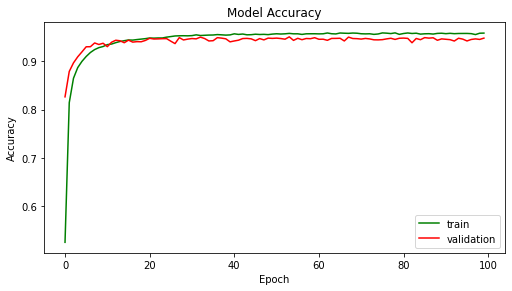

In [20]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
plt.plot(his1.history['accuracy'], color="green")
plt.plot(his1.history['val_accuracy'], color="red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('./plots/svg/model_accuracy.svg')
plt.savefig('./plots/png/model_accuracy.png')


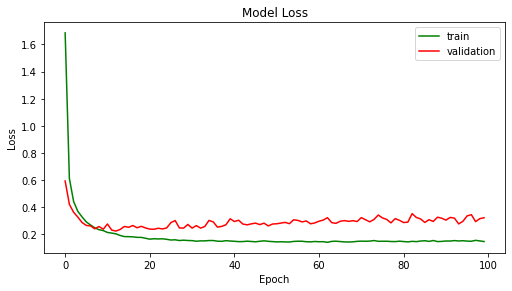

In [22]:
# "Loss"
plt.figure(figsize=[8, 4])
plt.plot(his1.history['loss'], color="green")
plt.plot(his1.history['val_loss'], color="red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.show()

plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('./plots/svg/loss.svg')
plt.savefig('./plots/png/loss.png')


/home/nsssayom/Desktop/compound-bangla-char/env/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(12639, 50)
Confusion matrix, without normalization
[[280   0   0 ...   0   3   0]
 [  0 264   0 ...   1   0   0]
 [  1   0 254 ...   0   0   0]
 ...
 [  0   0   0 ... 187   0   0]
 [  0   0   0 ...   0 210   1]
 [  0   0   0 ...   0   0 201]]


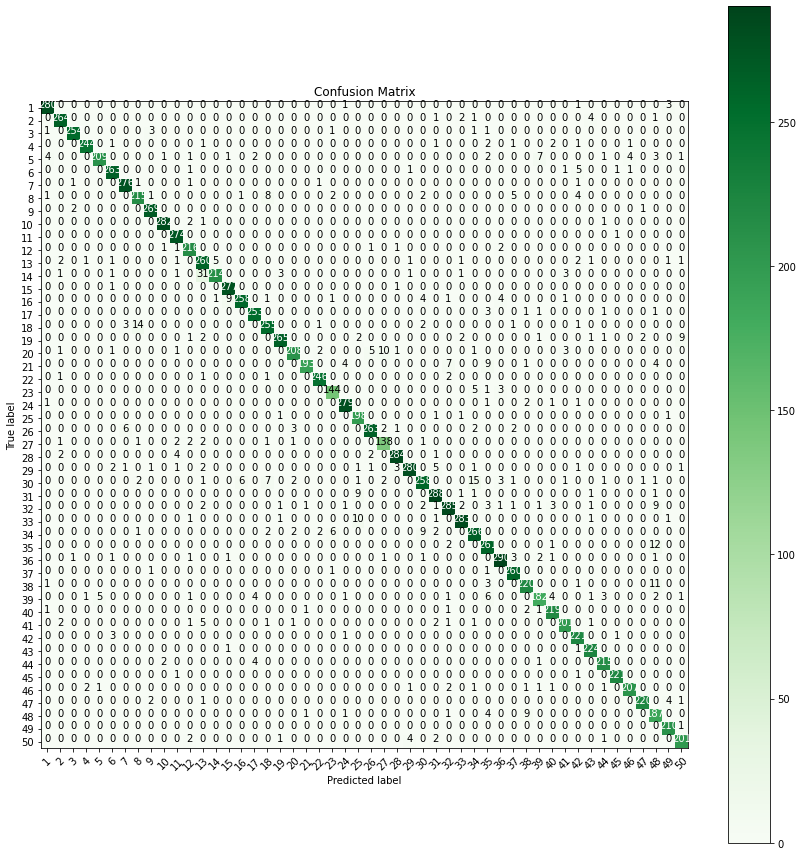

In [23]:
Y_pred = model.predict_generator(
    validation_generator, nb_validation_samples // batch_size+1)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                  '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                  '21', '22', '23', '24', '25', '26', '27', '28', '29', '30',
                  '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
                  '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'
                  ]
#print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]), ):
        plt.text(j, i, cm[i, j, ],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plot_confusion_matrix(cm=cm, classes=target_names, title='Confusion Matrix')
plt.savefig('./plots/svg/cf_mat.svg')
plt.savefig('./plots/png/cf_mat.png')
